In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [41]:
df = pd.read_csv('data/medicalmalpractice.csv')

In [42]:
# Show top 5 record
df.head()

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender
0,57041,7,62,1,2,Family Practice,Private,Male
1,324976,6,38,1,2,OBGYN,No Insurance,Female
2,135383,4,34,1,2,Cardiology,Unknown,Male
3,829742,7,42,1,1,Pediatrics,No Insurance,Female
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female


In [43]:
# Feature Engineering
# Create Age Group
# include all ages outside the specified bins
df['Age Group'] = pd.cut(df['Age'], bins=[-float('inf'), 20, 40, 60, 80, float('inf')], labels=['0-20', '21-40', '41-60', '61-80', '80+'])

# Create Interaction Term
df['Attorney_Severity'] = df['Private Attorney'] * df['Severity']

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79210 entries, 0 to 79209
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Amount             79210 non-null  int64   
 1   Severity           79210 non-null  int64   
 2   Age                79210 non-null  int64   
 3   Private Attorney   79210 non-null  int64   
 4   Marital Status     79210 non-null  int64   
 5   Specialty          79210 non-null  object  
 6   Insurance          79210 non-null  object  
 7   Gender             79210 non-null  object  
 8   Age Group          79121 non-null  category
 9   Severity Category  78545 non-null  category
 10  Attorney_Severity  79210 non-null  int64   
dtypes: category(2), int64(6), object(3)
memory usage: 5.6+ MB


#### Preparing X and Y variables

In [45]:
X = df.drop(columns=['Amount','Age'],axis=1)

In [46]:
X.head()

,Private Attorney,Marital Status,Specialty,Insurance,Gender,Age Group,Severity Category,Attorney_Severity
0,1,2,Family Practice,Private,Male,61-80,High,7
1,1,2,OBGYN,No Insurance,Female,21-40,Medium,6
2,1,2,Cardiology,Unknown,Male,21-40,Medium,4
3,1,1,Pediatrics,No Insurance,Female,41-60,High,7
4,0,2,OBGYN,Medicare/Medicaid,Female,41-60,Low,0


In [47]:
y = df['Amount']

In [48]:
y

0         57041
1        324976
2        135383
3        829742
4        197675
          ...  
79205     25305
79206     43098
79207     35398
79208    154228
79209    168298
Name: Amount, Length: 79210, dtype: int64

In [51]:
# create column Transformer with 3 types of transformers

# Handling categorical features
num_features = X.select_dtypes(exclude=['object', 'category']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Fit OneHotEncoder separately to get feature names
oh_transformer = OneHotEncoder(handle_unknown='ignore')
oh_transformer.fit(X[cat_features])
ohe_feature_names = oh_transformer.get_feature_names_out(cat_features).tolist()

# Define the full preprocessor
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [52]:
# X = preprocessor.fit_transform(X)
# Fit the preprocessor and convert to DataFrame
X_transformed = preprocessor.fit_transform(X).toarray()
transformed_feature_names = ohe_feature_names + num_features.tolist()

# Convert transformed data to DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)

In [53]:
X_transformed_df.shape

(79210, 40)

In [54]:
# Seperate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((63368, 40), (15842, 40))

#### Create an Evaluate Function to give all metrics after model Training

In [55]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [56]:
# Train and Evaluate Multiple Models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

# Results
results_df = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 158497.1878
- Mean Absolute Error: 110686.7874
- R2 Score: 0.3225
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 160254.9923
- Mean Absolute Error: 112037.4017
- R2 Score: 0.3274




c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.781e+13, tolerance: 2.350e+11
  model = cd_fast.enet_coordinate_descent(


Lasso
Model performance for Training set
- Root Mean Squared Error: 158491.2455
- Mean Absolute Error: 110747.0831
- R2 Score: 0.3225
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 160240.0561
- Mean Absolute Error: 112088.0459
- R2 Score: 0.3275


Ridge
Model performance for Training set
- Root Mean Squared Error: 158491.2767
- Mean Absolute Error: 110748.7239
- R2 Score: 0.3225
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 160239.7229
- Mean Absolute Error: 112089.2074
- R2 Score: 0.3275


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 119984.0182
- Mean Absolute Error: 69747.8346
- R2 Score: 0.6117
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 129868.1423
- Mean Absolute Error: 77662.6309
- R2 Score: 0.5583


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 108589.0817
- Mean Absolu

In [57]:
print(results_df)

                Model Name  R2_Score
7    CatBoosting Regressor  0.633078
6             XGBRegressor  0.632187
5  Random Forest Regressor  0.624022
4            Decision Tree  0.618572
3    K-Neighbors Regressor  0.558296
2                    Ridge  0.327540
1                    Lasso  0.327537
0        Linear Regression  0.327412
8       AdaBoost Regressor  0.256848


## Key Observations:
#### Boosting models (XGBoost and CatBoost) significantly outperform other models, indicating that the non-linear relationships in the data are best captured by these models.
#### Linear models (Linear Regression, Lasso, Ridge) perform poorly (R² ~ 0.327), suggesting that the relationship between the features and target (Amount) is non-linear.
#### K-Neighbors Regressor performed surprisingly well, which shows there might be some local patterns in the data.

In [58]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth' : [3, 5, 7],
    'learning_rate' : [0.01, 0.1, 0.2],
}

xgb = XGBRegressor()

xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=3, scoring='r2', verbose=2, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost R2 Score:", xgb_grid.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best XGBoost R2 Score: 0.6406054818396253


In [59]:
# Hyperparameter Tuning for CatBoost
cat_params = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
}

cat = CatBoostRegressor(verbose=0)

cat_grid = GridSearchCV(estimator=cat, param_grid=cat_params, cv=3, scoring='r2', verbose=2, n_jobs=-1)
cat_grid.fit(X_train, y_train)

print("Best CatBoost Parameters:", cat_grid.best_params_)
print("Best CatBoost R2 Score:", cat_grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best CatBoost Parameters: {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}
Best CatBoost R2 Score: 0.6418675391545557


## XGBRegressor

In [60]:
xgb_model = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=300)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the XGBRegressor model after hyper parameter tuning is %.2f" %score)

Accuracy of the XGBRegressor model after hyper parameter tuning is 63.44


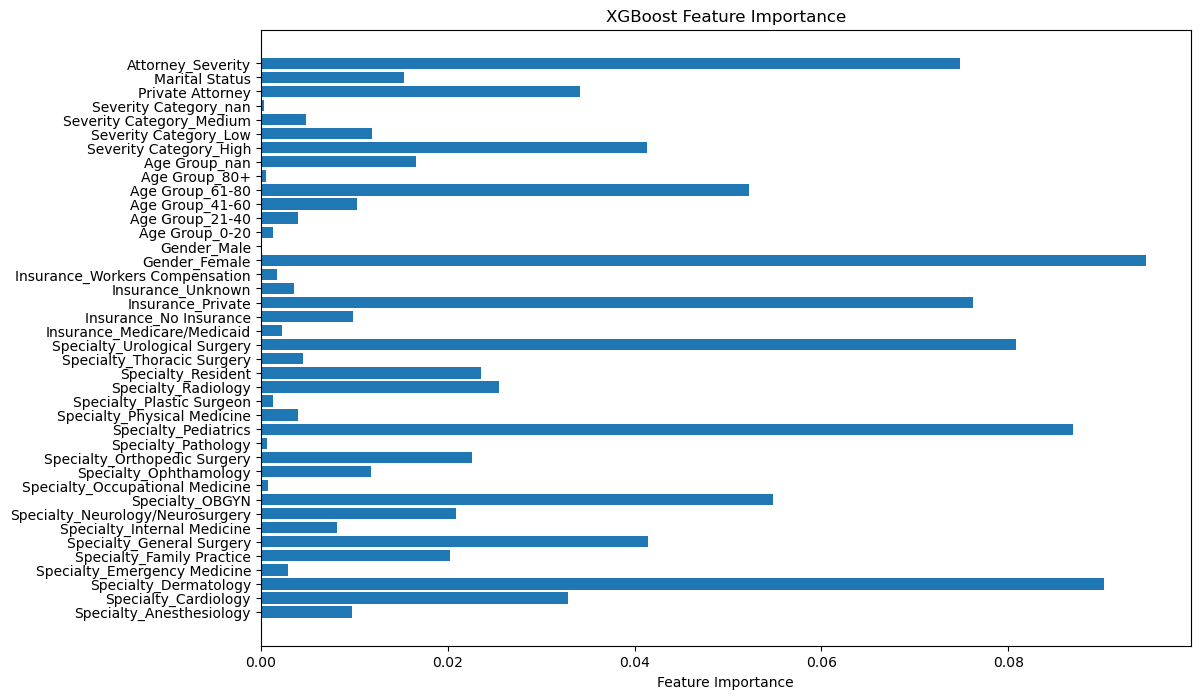

In [61]:
# Feature Importance Plot for XGBoost
best_xgb = xgb_grid.best_estimator_
xgb_importance = best_xgb.feature_importances_

plt.figure(figsize=(12, 8))
plt.barh(transformed_feature_names, xgb_importance)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

## Key Observations from the XGBoost Feature Importance Plot:

In the XGBoost plot, the most important features are:
1. Gender_Female – The most significant predictor in the model.
   Female patients tend to have higher claim amounts, possibly due to gender-specific procedures or higher expectations of care.
2. Specialty_Dermatology – The second most important feature.
   Although dermatology is generally considered low risk, specific high-value claims (e.g., cosmetic procedures) might be influencing this feature's importance.
3. Attorney_Severity – An interaction term combining private attorney and severity of the case.
   It shows that having a private attorney in high-severity cases significantly increases claim amounts.
4. Specialty_Pediatrics – Pediatric cases tend to result in higher claims due to the lifelong impacts on children caused by medical errors
5. Specialty_Urological Surgery – Urological surgeries involve complex procedures that can have severe long-term consequences, leading to higher claim amounts..
6. Insurance_Private – Patients with private insurance may have higher expectations of care and, therefore, may be more likely to file large claims

Other Notable Features:
1. Age Group_61-80 – Claimants in the 61-80 age group tend to have higher claim amounts, likely due to more complex procedures and higher medical risks.
2. Specialty_Emergency Medicine – Although not the top feature, it shows that emergency cases are still high risk and can result in large claims.

Insights from CatBoost Plot:
1. Gender and Specialty play a crucial role in predicting claim amounts.
2. Legal representation (Attorney_Severity) is a key factor in determining the size of settlements.
3. Severity of the case remains one of the most critical predictors of claim amounts.
4. Patients with private insurance tend to file larger claims, possibly due to higher expectations of care.

## Business Interpretation:

1. Attorney_Severity is the most significant factor in determining claim amounts.
   This suggests that having a private attorney in high-severity cases significantly increases the size of settlements.

2. Gender (Female) plays a critical role in claim amounts.
   Female patients tend to have higher claims, possibly due to gender-specific procedures and higher expectations of care.

3. Specialty_Dermatology shows unexpectedly high importance.
   This could be driven by cosmetic procedures or specific high-value claims, where patients expect perfect outcomes and are more likely to sue if dissatisfied.

4. Insurance_Private is an important predictor of claim amounts.
Patients with private insurance tend to file higher claims, possibly due to higher expectations of care quality.

## CatBoosting Regressor

In [62]:
cat_model = CatBoostRegressor(depth=8, iterations=500, learning_rate=0.1, verbose=0)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the CatBoost Regressor model after hyper parameter tuning is %.2f" %score)

Accuracy of the CatBoost Regressor model after hyper parameter tuning is 63.56


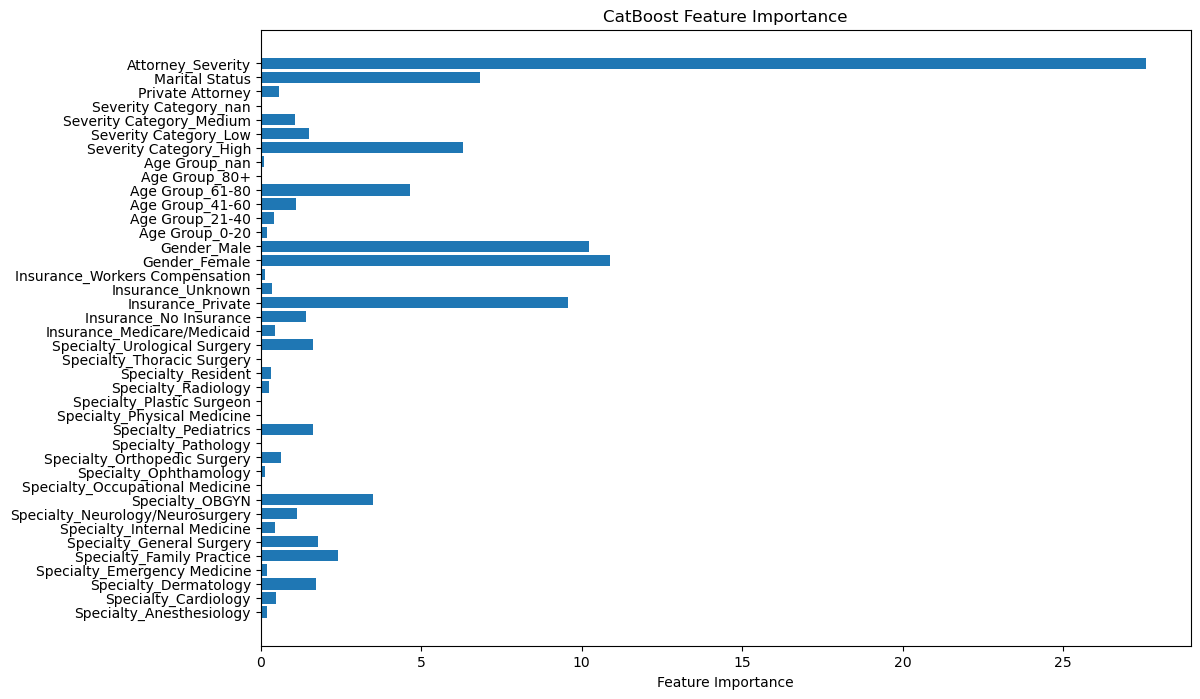

In [63]:
# Get feature importance from the best CatBoost model
best_cat = cat_grid.best_estimator_
cat_importance = best_cat.get_feature_importance()

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(transformed_feature_names, cat_importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

## Key Observations from the CatBoost Feature Importance Plot:

In the CatBoost plot, the most important features are:
1. Attorney_Severity – The most significant predictor in the model.
   This interaction term shows that having a private attorney in high-severity cases significantly increases the claim amount. It reflects that legal representation and case severity are the key drivers of large settlements.
2. Marital Status – The second most important feature in the model.
   Marital status might impact damages awarded for emotional distress or economic compensation for the spouse in case of death or permanent disability.
3. Severity Category_High – A key indicator of high-severity cases.
   High-severity cases naturally lead to higher claim amounts, as the damages are more significant.
4. Age Group_61-80 – Claimants in this age group tend to have higher claim amounts.
   Older patients often require more complex procedures and longer recovery times, which increases the cost of care and settlements.
5. Gender_Female – Female claimants tend to have higher claim amounts compared to males.
   This may be related to gender-specific procedures or higher awards for emotional damages.
6. Insurance_Private – Patients with private insurance are more likely to file higher claims.
   This may be because private insurance holders tend to have higher expectations of care quality.

Other Notable Features:
1. Specialty_Dermatology – Unexpectedly high feature importance, possibly due to outlier cases or cosmetic procedures where patients expect perfect outcomes.
2. Specialty_Pediatrics – Pediatric cases involve high-severity incidents that can have lifelong impacts, leading to higher claims.

Insights from CatBoost Plot:
1. Attorney and severity interactions are the most important predictors of claim amounts.
2. Demographic factors such as age group, gender, and marital status significantly impact claim size.
3. Insurance type and medical specialty also play a role, with private insurance holders and high-risk specialties tending to have higher claims.

## Business Interpretation:

1. Attorney_Severity is by far the most important feature in predicting claim amounts.
   Legal representation in high-severity cases leads to significantly larger settlements.

2. Marital Status impacts claim amounts.
   Married claimants may receive higher settlements due to compensation for loss of companionship or emotional distress.

3. Severity Category_High is a critical factor.
   High-severity cases naturally lead to higher claim amounts, as the damages are more severe.

4. Age Group (61-80) plays an important role.
   Older patients tend to require more complex medical procedures, which increases the size of claims.

#### Difference between Actual and Predicted Values (with CatBoost)

In [66]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
19537,56018,96345.274210,-40327.274210
44265,70790,99424.408323,-28634.408323
23642,157511,90671.257175,66839.742825
43853,19714,23805.607209,-4091.607209
65390,202842,96158.713107,106683.286893
...,...,...,...
73382,162146,201820.531219,-39674.531219
72962,59867,116284.690846,-56417.690846
30191,108392,118741.013910,-10349.013910
62849,740137,513176.663181,226960.336819
